# Variational Autoencoder

In [1]:

import logging
from functools import partial

from fastai.basics import *
from fastai.learner import Learner
from fastai.callback.all import *
from fastai.callback.all import EarlyStoppingCallback
from fastai.torch_basics import *

import torch

from IPython.display import display

from torch.nn import Sigmoid

import pandas as pd

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import vaep
import vaep.nb
from vaep.io import datasplits
from vaep.models import ae
import vaep.models as models
import vaep.model
from vaep.analyzers import analyzers


# overwriting Recorder callback with custom plot_loss
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss


logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '256_128' for the encoder, reverse will be use for decoder
hidden_layers: str = '256_128'
# force_train:bool = True # Force training when saved model could be used. Per default re-train model
patience: int = 50  # Patience for early stopping
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'VAE'  # model name
model_key: str = 'VAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
folder_experiment = "runs/example"
file_format = "csv"
latent_dim = 25
batch_size = 10
epochs_max = 5
hidden_layers = "512_256"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
model_key = "VAE"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/example',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'epochs_max': 5,
 'batch_size': 10,
 'cuda': False,
 'latent_dim': 25,
 'hidden_layers': '512_256',
 'patience': 50,
 'sample_idx_position': 0,
 'model': 'VAE',
 'model_key': 'VAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 10,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epochs_max': 5,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'hidden_layers': [512, 256],
 'latent_dim': 25,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070  PPP4R2       24.944
2020_02_10_15_41_Q-Exactive-HF-X-Orbitrap_6070  EIF4G1       34.042
2020_05_14_14_46_Q-Exactive-HF-X-Orbitrap_6070  TIMM9        26.361
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070  SNX3         27.881
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070  INTS7        28.837
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = vaep.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

Gene Names
AAR2     45
ABCB6    35
ABHD11   30
ACAD9    50
ACTL6A   49
Name: freq, dtype: int64

### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [13]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470


In [14]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,859.000
mean,28.270
std,2.543
min,22.254
25%,26.477
50%,28.068
75%,30.064
max,35.919


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189


### Add interpolation performance

### Fill Validation data with potentially missing features

In [16]:
data.train_X

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,26.917,NaN,NaN,NaN,30.626,33.367,31.569,25.330,31.101,28.930,...,NaN,28.035,26.850,29.935,29.515,28.978,32.584,25.876,31.325,29.388
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,27.112,27.469,31.484,29.713,NaN,29.224,NaN,...,NaN,27.500,NaN,26.462,26.910,26.934,NaN,26.345,29.825,27.157
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,24.846,NaN,NaN,27.670,29.390,NaN,30.087,NaN,30.444,28.851,...,24.957,NaN,23.529,28.026,27.176,27.066,31.607,27.569,30.546,24.252
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,25.971,NaN,NaN,28.528,NaN,32.321,30.205,NaN,30.990,28.655,...,24.553,27.959,26.925,28.557,28.216,27.650,31.864,26.361,30.039,26.318


In [17]:
data.val_y  # potentially has less features

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ADAM10,AHSA1,AK3,AKR1A1,...,WBP2,WBSCR16,WDR18,WDR33,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.618,32.214,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.873,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.618,32.214,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variational Autoencoder

### Analysis: DataLoaders, Model, transform

In [19]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

### Analysis: DataLoaders, Model

In [20]:

analysis = ae.AutoEncoderAnalysis(  # datasplits=data,
    train_df=data.train_X,
    val_df=data.val_y,
    model=models.vae.VAE,
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      # last_encoder_activation=None,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    transform=default_pipeline,
    decode=['normalize'],
    bs=args.batch_size)
args.n_params = analysis.n_params_ae
if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=376, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Training



In [21]:
results = []
loss_fct = partial(models.vae.loss_fct, results=results)

In [22]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=loss_fct,
                         cbs=[ae.ModelAdapterVAE(),
                              EarlyStoppingCallback(patience=args.patience)
                              ])

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE, CastToTensor]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : [ModelAdapterVAE]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [23]:
# learn.summary()

SuggestedLRs(valley=0.0008317637839354575)

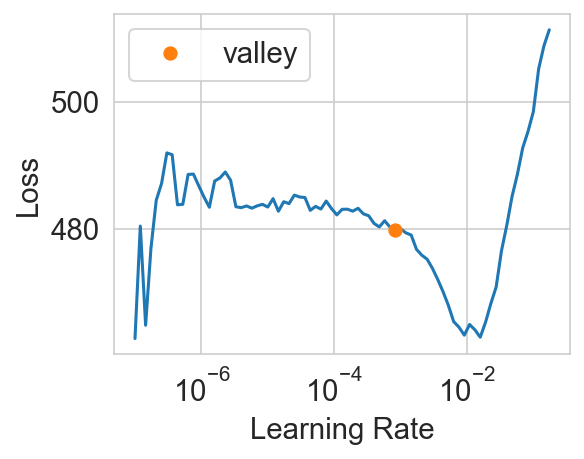

In [24]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

In [25]:
results.clear()  # reset results

dump model config

In [26]:
# needs class as argument, not instance, but serialization needs instance
analysis.params['last_decoder_activation'] = Sigmoid()

vaep.io.dump_json(
    vaep.io.parse_dict(
        analysis.params, types=[
            (torch.nn.modules.module.Module, lambda m: str(m))
        ]),
    args.out_models / TEMPLATE_MODEL_PARAMS.format(args.model_key))

# restore original value
analysis.params['last_decoder_activation'] = Sigmoid

In [27]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,483.905060,27.525297,00:00
1,479.015106,27.952934,00:00
2,468.181274,29.970343,00:00
3,456.850586,31.622646,00:00
4,448.326630,31.199547,00:00


Save number of actually trained epochs

In [28]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

5

#### Loss normalized by total number of measurements

vaep.plotting - INFO     Saved Figures to runs/example/figures/vae_training


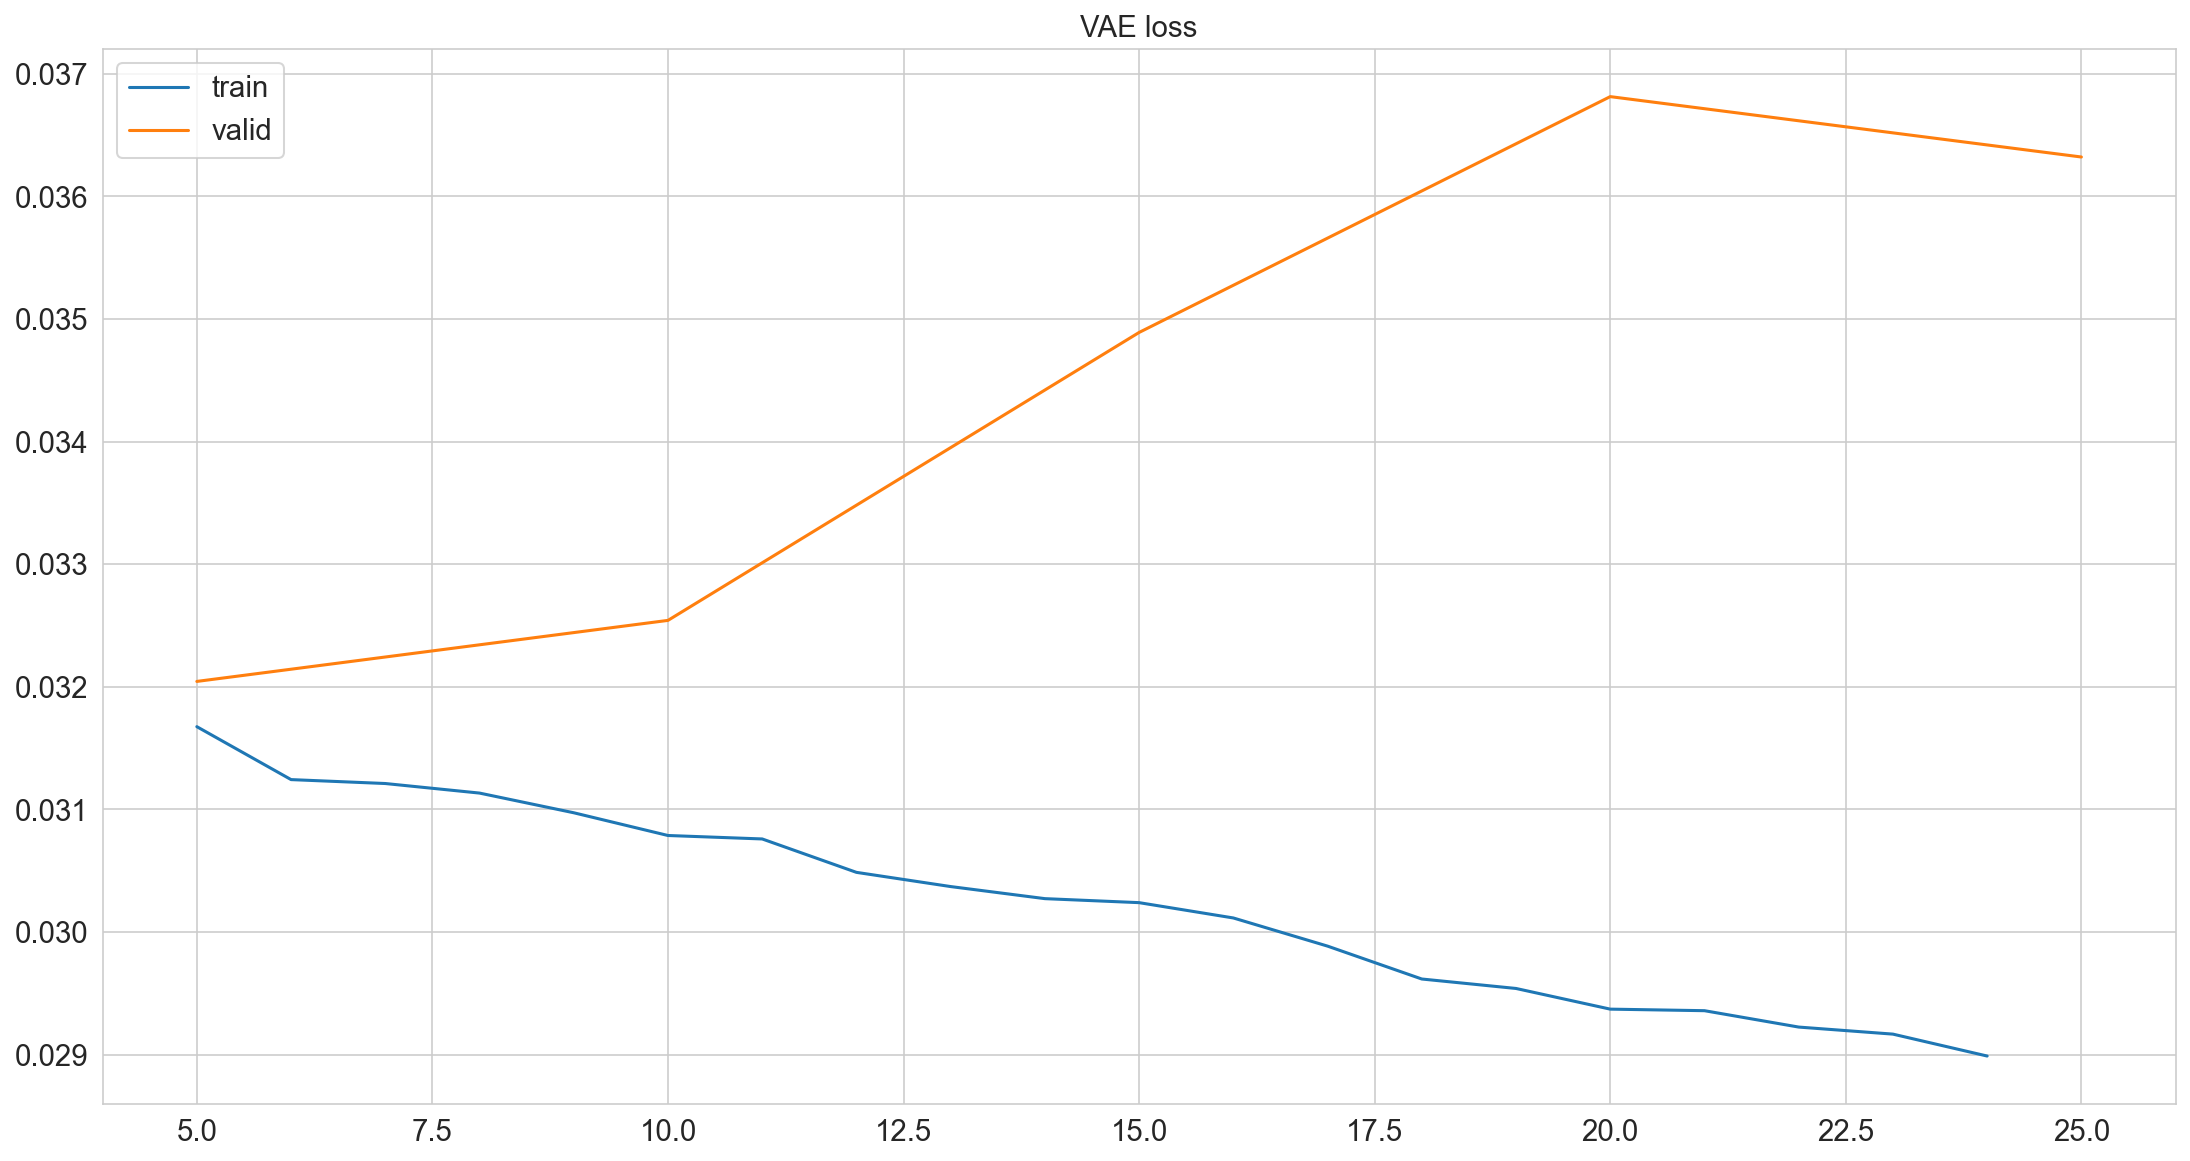

In [29]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

### Predictions
create predictions and select validation data predictions

In [30]:
analysis.model.eval()
pred, target = res = ae.get_preds_from_df(df=data.train_X, learn=analysis.learn,
                                          position_pred_tuple=0,
                                          transformer=analysis.transform)
pred = pred.stack()
pred

Sample ID                                       Gene Names
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAR2         26.798
                                                ABCB6        25.478
                                                ABHD11       24.956
                                                ACAD9        28.540
                                                ACTL6A       29.872
                                                              ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  WNK1         27.741
                                                YBX1         32.377
                                                YTHDF1       25.816
                                                YWHAH        29.831
                                                ZNF326       28.156
Length: 18800, dtype: float32

In [31]:
val_pred_simulated_na['VAE'] = pred  # 'model_key' ?
val_pred_simulated_na

,,observed,VAE
Sample ID,Gene Names,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,30.482
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,27.096
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,27.106
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,27.414
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,27.637
...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,25.611
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,27.991
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,28.190


In [32]:
test_pred_simulated_na['VAE'] = pred  # model_key?
test_pred_simulated_na

observed    VAE
Sample ID                                      Gene Names                 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF          23.248 26.424
                                               CENPH         25.045 25.117
                                               CLPP          27.745 27.483
                                               GNAI1         24.335 26.779
                                               KIAA1143      26.901 26.930
...                                                             ...    ...
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9         27.658 27.051
                                               PTPN1         29.024 28.517
                                               RDH13         28.720 27.105
                                               RNASEH2C      26.742 25.692
                                               SH3BGRL3      29.162 29.076

[859 rows x 2 columns]

save missing values predictions

In [33]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID                                       Gene Names 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  ARMCX3        25.198
                                                BDH2          25.019
                                                CCBL2         26.189
                                                COMMD5        25.071
                                                DNAJC10       26.003
                                                               ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  TMEM261       25.504
                                                TRMT2A        25.998
                                                TSNAX;DISC1   27.209
                                                UTRN          26.116
                                                VPS11         25.553
Name: intensity, Length: 1616, dtype: float32

### Plots

- validation data

In [34]:
analysis.model = analysis.model.cpu()
df_latent = vaep.model.get_latent_space(analysis.model.get_mu_and_logvar,
                                        dl=analysis.dls.valid,
                                        dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10,...,latent dimension 16,latent dimension 17,latent dimension 18,latent dimension 19,latent dimension 20,latent dimension 21,latent dimension 22,latent dimension 23,latent dimension 24,latent dimension 25
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,0.247,-0.135,-0.072,0.022,0.113,-0.031,0.403,0.064,0.238,-0.378,...,-0.104,-0.149,0.303,-0.031,0.006,0.120,-0.251,-0.125,0.175,0.219
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,0.608,-0.082,0.429,0.225,-0.016,0.153,0.663,-0.108,0.175,-0.377,...,0.154,0.127,0.548,-0.042,-0.091,-0.023,-0.554,-0.269,0.010,0.423
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,-0.354,0.362,-0.153,-0.248,0.093,-0.158,-0.095,-0.013,0.033,0.297,...,-0.235,0.080,-0.195,-0.216,0.297,0.125,-0.140,0.174,0.660,-0.161
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,0.700,-0.341,0.327,0.496,0.056,0.248,0.802,-0.098,0.357,-0.582,...,0.390,-0.103,0.852,0.046,-0.285,0.018,-0.641,-0.061,-0.165,0.447
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,-0.909,0.326,-0.257,-0.771,-0.300,-0.380,-0.553,0.162,-0.338,0.511,...,-0.337,0.003,-0.710,-0.210,0.559,-0.124,0.314,0.206,0.671,-0.353
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,-1.468,0.405,-0.372,-0.829,-0.041,-0.698,-1.125,0.108,-0.569,0.741,...,-0.287,0.186,-1.181,-0.439,0.752,-0.261,0.242,0.623,1.001,-0.522
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,1.284,-0.611,1.312,1.186,-0.643,1.204,0.765,-0.592,0.322,-1.508,...,1.164,0.119,0.853,0.275,-0.327,-0.801,-1.185,0.356,-1.002,0.946
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,0.293,-1.001,0.312,0.144,-0.014,0.435,0.128,-0.572,-0.108,-0.266,...,0.401,-0.065,0.451,0.240,-0.026,-0.365,-0.779,0.054,-0.749,0.641
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,-0.497,-0.152,-0.310,-0.339,-0.160,-0.237,-0.277,-0.038,-0.289,-0.113,...,-0.427,-0.039,-0.233,-0.038,0.324,-0.222,0.140,0.294,-0.052,0.069


In [35]:
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [36]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

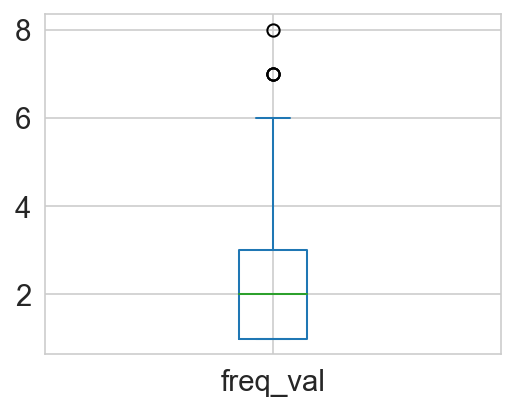

In [37]:
feat_freq_val = val_pred_simulated_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [38]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

1   101
2    85
3    89
4    41
5    16
Name: freq_val, dtype: int64

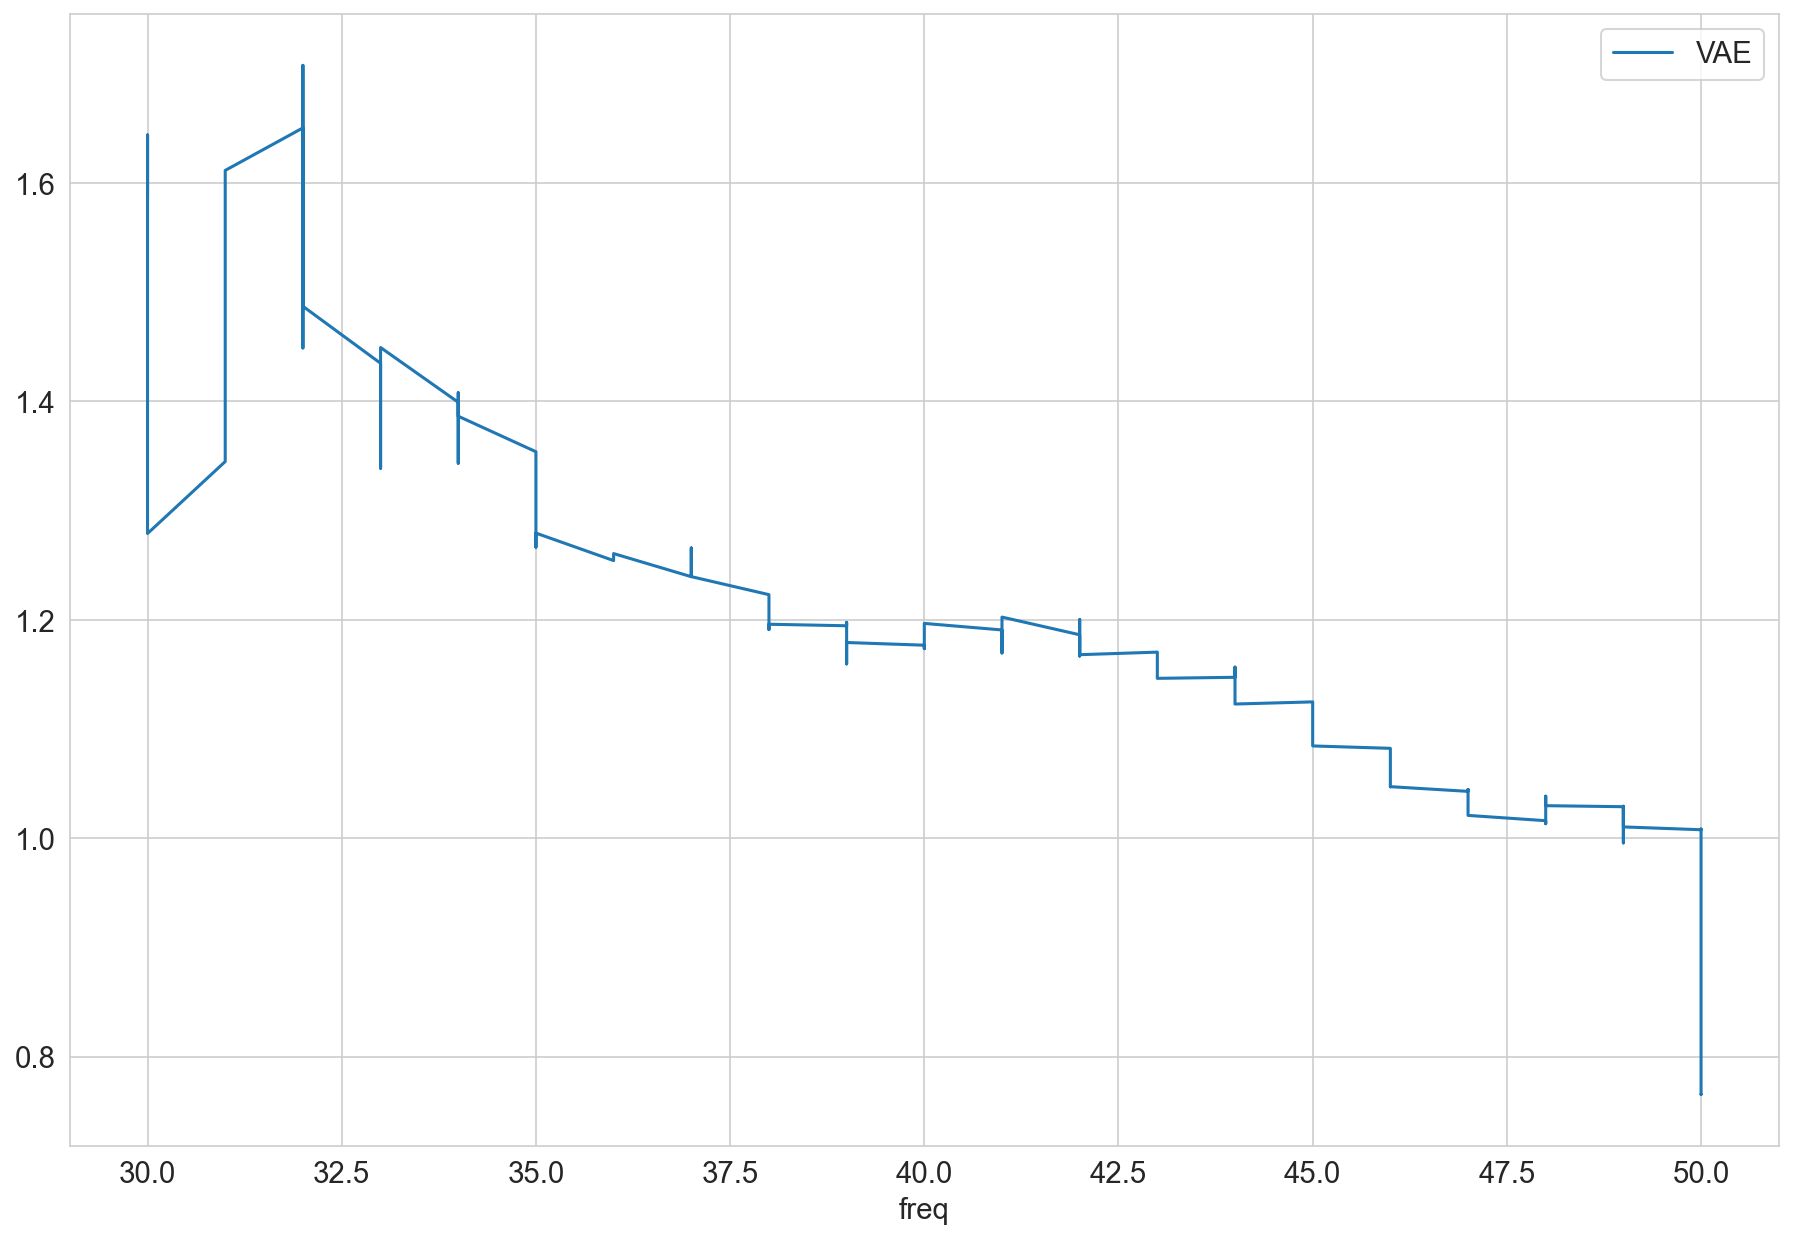

In [39]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-1]] = errors_val[errors_val.columns[:-1]
                                                          ].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [40]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

VAE      
            mean count
Gene Names            
AAR2       1.045     2
ABCB6      3.156     3
ABHD11     1.409     4
ACAD9      0.184     2
ACTL6A     0.845     2
...          ...   ...
WNK1       0.553     3
YBX1       0.500     3
YTHDF1     1.568     2
YWHAH      0.067     1
ZNF326     1.489     3

[344 rows x 2 columns]

In [41]:
errors_val

,,VAE
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,-0.464
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,-0.152
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,-2.204
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,3.062
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,-1.613
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,1.317
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,-0.479
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,-1.280


## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [42]:
# papermill_description=metrics
# d_metrics = models.Metrics(no_na_key='NA interpolated', with_na_key='NA not interpolated')
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [43]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 1.3343583442146958,
  'MAE': 0.8622824275865457,
  'N': 859,
  'prop': 1.0}}

### Test Datasplit


In [44]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 1.2418748532926493,
  'MAE': 0.8496583955493243,
  'N': 859,
  'prop': 1.0}}

Save all metrics as json

In [45]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'VAE': { 'MAE': 0.8496583955493243,
                                  'MSE': 1.2418748532926493,
                                  'N': 859,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'VAE': { 'MAE': 0.8622824275865457,
                                   'MSE': 1.3343583442146958,
                                   'N': 859,
                                   'prop': 1.0}}}

In [46]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
VAE   MSE                       1.334              1.242
      MAE                       0.862              0.850
      N                       859.000            859.000
      prop                      1.000              1.000

## Save predictions

In [47]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [48]:
figures  # switch to fnames?

{}

In [49]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 376,
 'batch_size': 10,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epoch_trained': 5,
 'epochs_max': 5,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'hidden_layers': [512, 256],
 'latent_dim': 25,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'n_params': 864290,
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}